In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_path = "/content/drive/MyDrive/Cars/car_models_data"

In [ ]:
import os
import glob
import numpy as np

def get_model_name(m_string):
  return m_string.split("/")[-2].split(" ")[0]

classes_txt_file = "/content/drive/MyDrive/Cars/trunc_car_models.txt"
classes = []
with open(classes_txt_file) as f:
  for line in f.readlines():
    classes.append(line.strip())

classes = list(sorted(classes))

# num_classes = 5
# classes = classes[0:3]
print(classes)

res_dict = {}
all_img_paths = glob.glob(os.path.join(dataset_path, "car_data", "car_data", "train", "*", "*"))
filtered_classes = classes #[]
all_img_paths = list(filter(lambda x: get_model_name(x) in filtered_classes, all_img_paths))

for img_path in all_img_paths:
  model_name = get_model_name(img_path)

  if model_name not in res_dict:
    res_dict[model_name] = []
  res_dict[model_name].append(img_path)



# print(len(filtered_classes))
# print(res_dict)
# for key, value in res_dict.items():
#   if len(value) > 100:
#     filtered_classes.append(key)

# all_img_paths = glob.glob(os.path.join(dataset_path, "car_data", "car_data", "train", "*", "*"))

# for value in res_dict.items():
#   print(value)

['Audi', 'BMW', 'Chevrolet', 'Daewoo', 'FIAT', 'Ford', 'Honda', 'Hyundai', 'Infiniti', 'Mazda', 'Mercedes-Benz', 'Mitsubishi', 'Nissan', 'Tesla', 'Toyota', 'Volkswagen', 'Volvo']


In [ ]:
train_img_paths = [] 
val_img_paths = []
for key, value in res_dict.items():
    np.random.shuffle(value)
    len_img_paths = len(value)
    train_img_paths += value[0:int(len_img_paths * 0.7)]
    val_img_paths += value[int(len_img_paths * 0.7):]

# should be equal
print(len(filtered_classes))
print(len(set(list(map(lambda x: get_model_name(x), train_img_paths)))))
print(len(set(list(map(lambda x: get_model_name(x), val_img_paths)))))

17
17
17


In [ ]:
import tensorflow as tf  
import cv2
from PIL import Image, ImageOps
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

class DataGenerator(tf.keras.utils.Sequence):

  def __init__(self, paths, classes):
    self.batch_size = 8
    self.dim = (224, 224, 3)
    self.img_paths = paths #

    self.classes = classes
    
    self.temp_img = None

    # classses_ids = np.arange(0, len(self.unique_classes))
    
    self.indexes = np.arange(len(self.img_paths))


  def on_epoch_end(self):
    print("on_epoch_end")
    np.random.shuffle(self.indexes)

  def get_model_name(self, m_string):
    return m_string.split("/")[-2].split(" ")[0]

  def __len__(self):
    return int(len(self.img_paths) / self.batch_size)

  def __data_generation(self, img_paths):
      'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
      # Initialization
      X = np.empty((self.batch_size, *self.dim))
      y = np.empty((self.batch_size), dtype=int)

      # Generate data
      for i, img_path in enumerate(img_paths):
          # Store sample
          img = Image.open(img_path)#.convert('L')
          img = self.resize_with_padding(img, (224, 224))
          # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

          if np.asarray(img).ndim == 3:
            self.temp_img = img_path #self.resize_with_padding(img, (224, 224))


          if np.asarray(img).ndim == 2:
            img_path = self.temp_img
            img = Image.open(img_path) 
            img = self.resize_with_padding(img, (224, 224))

          X[i,] = preprocess_input(np.asarray(img)) 
          y[i] = self.classes.index(self.get_model_name(img_path))

      return X, y #tf.keras.utils.to_categorical(y, num_classes=len(self.classes))

  def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        img_paths = [self.img_paths[k] for k in indexes]
        item = self.__data_generation(img_paths)

        return item


  def padding(self, img, expected_size):
      desired_size = expected_size
      delta_width = desired_size - img.size[0]
      delta_height = desired_size - img.size[1]
      pad_width = delta_width // 2
      pad_height = delta_height // 2
      padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
      return ImageOps.expand(img, padding)


  def resize_with_padding(self, img, expected_size):
      img.thumbnail((expected_size[0], expected_size[1]))
      # print(img.size)
      delta_width = expected_size[0] - img.size[0]
      delta_height = expected_size[1] - img.size[1]
      pad_width = delta_width // 2
      pad_height = delta_height // 2
      padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
      return ImageOps.expand(img, padding)

In [ ]:
print(len(filtered_classes))
train_dg = DataGenerator(train_img_paths, filtered_classes)
val_dg = DataGenerator(val_img_paths, filtered_classes)

17


(8, 224, 224, 3)


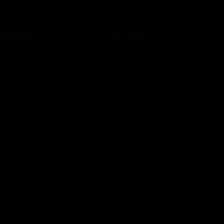

In [ ]:
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt 

# for item in train_dg:
#   print(item[1])

item = train_dg[7]#[0]
print(item[0].shape)
cv2_imshow(item[0][0])

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html
from keras.layers import LeakyReLU

def get_simple_model(input_shape, num_classes):
    print("num_classes", num_classes)
      # Input layer
    input_layer = tf.keras.Input(shape=input_shape, name="Input")
    input_layer = tf.keras.layers.Rescaling(1./255)(input_layer)
    input_layer = tf.keras.layers.RandomFlip("horizontal_and_vertical")(input_layer)
    input_layer = tf.keras.layers.RandomRotation(0.2)(input_layer)
    # Base layer
    base_model = tf.keras.layers.Conv2D(16, 3, padding='same', activation=LeakyReLU(alpha=0.001))(input_layer)
    base_model = tf.keras.layers.MaxPooling2D()(base_model)
    base_model = tf.keras.layers.Conv2D(32, 3, padding='same', activation=LeakyReLU(alpha=0.001))(base_model)
    base_model = tf.keras.layers.MaxPooling2D()(base_model)
    base_model = tf.keras.layers.Conv2D(64, 3, padding='same', activation=LeakyReLU(alpha=0.001))(base_model)
    base_model = tf.keras.layers.MaxPooling2D()(base_model)
    base_model = tf.keras.layers.Conv2D(128, 3, padding='same', activation=LeakyReLU(alpha=0.001))(base_model)
    base_model = tf.keras.layers.MaxPooling2D()(base_model)
    base_model = tf.keras.layers.Flatten()(base_model)
    # Output layer
    output_layer = tf.keras.layers.Dense(num_classes, name="Output")(base_model)
    # Compile model
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

    return model

def get_model(input_shape, num_classes):
  base_model =  tf.keras.applications.mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False) # replace with simpler CNN # skip some classes # grayscale #augmentation 
  for index, layer in enumerate(base_model.layers):
    # print(index > len(base_model.layers) * 0.95)
    layer.trainable = index > len(base_model.layers) * 0.7


  inputs = tf.keras.Input(shape=input_shape)
  x = base_model(inputs)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  # A Dense classifier with a single unit (binary classification)
  outputs = tf.keras.layers.Dense(num_classes)(x)
  model = tf.keras.Model(inputs, outputs)

  return model

In [ ]:
model = get_model((224, 224, 3), len(filtered_classes))
# model5.load_weights("/content/drive/MyDrive/Cars/checkpoints/cp.ckpt")
# model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0001), metrics=['accuracy'])

model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['sparse_categorical_accuracy'])

checkpoint_filepath = "/content/drive/MyDrive/Cars/checkpoints/MobileNetV2.ckpt"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_sparse_categorical_accuracy',
    mode='max',
    save_best_only=True)

model.fit_generator(generator=train_dg,
                              steps_per_epoch=1000,
                              epochs=15,
                              verbose=1,
                              callbacks=[model_checkpoint_callback],
                              workers=6,
                              use_multiprocessing=True,
                              # max_queue_size=config["max-queue-size"],
                              validation_data=val_dg)

9420800/9406464 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/15
1000/1000 [==============================] - 307s 292ms/step - loss: 2.3116 - sparse_categorical_accuracy: 0.2747 - val_loss: 10.1753 - val_sparse_categorical_accuracy: 0.3048
on_epoch_end
Epoch 2/15
1000/1000 [==============================] - 93s 92ms/step - loss: 1.4111 - sparse_categorical_accuracy: 0.5673 - val_loss: 14.9227 - val_sparse_categorical_accuracy: 0.0810
on_epoch_end
Epoch 3/15
1000/1000 [==============================] - 92s 92ms/step - loss: 0.7565 - sparse_categorical_accuracy: 0.7579 - val_loss: 9.8504 - val_sparse_categorical_accuracy: 0.2384
on_epoch_end
Epoch 4/15
 999/1000 [============================>.] - ETA: 0s - loss: 0.3728 - sparse_categorical_accuracy: 0.8764on_epoch_end
on_epoch_end
1000/1000 [==============================] - 94s 93ms/step - loss: 0.3726 - sparse_categorical_accuracy: 0.8765 - val_loss: 9.1621 - val_sparse_categorical_accuracy: 0.3164
on_epoch_end
Epoch 5/15
1000/1000 [==============================] - 94s 93ms/step - loss:

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# VALIDATION !
total_val_loss = 0
batch_size = 8
y_total_batch_val = np.empty((len(val_dg), 8))
y_pred_batch_val = np.empty((len(val_dg), 8))
# model = get_model((224, 224, 3), len(filtered_classes))
# model.load_weights("/content/drive/MyDrive/Cars/checkpoints/resnet.ckpt/resnetcp.ckpt")


for step, (x_batch_val, y_batch_val) in enumerate(val_dg):
    strt_index = step * batch_size
    y_total_batch_val[strt_index:strt_index+batch_size] = y_batch_val
    # print(x_batch_val.shape)
    val_logits = model(x_batch_val, training=False)

    y_pred_batch_val[strt_index:strt_index+8] = np.argmax(val_logits, axis=1)

print(classification_report(y_true=y_total_batch_val.flatten(),
                            y_pred=y_pred_batch_val.flatten(),
                            labels=np.arange(len(filtered_classes)),
                            target_names = filtered_classes, zero_division=0))

print(accuracy_score(y_true=y_total_batch_val.flatten(), y_pred=y_pred_batch_val.flatten()))
# model.save("{}/weights/{}/ep_{}".format(BASE_SAVE_FOLDER, "temp", epoch))

               precision    recall  f1-score   support

         Audi       0.55      0.87      0.67       180
          BMW       0.40      0.68      0.50       124
    Chevrolet       0.77      0.72      0.74       258
       Daewoo       0.00      0.00      0.00        40
         FIAT       1.00      0.50      0.67        32
         Ford       1.00      0.53      0.69       140
        Honda       1.00      0.20      0.33        80
      Hyundai       0.62      0.57      0.59       112
     Infiniti       0.25      1.00      0.40        24
        Mazda       0.00      0.00      0.00        16
Mercedes-Benz       1.00      0.13      0.24       120
   Mitsubishi       0.15      1.00      0.27        16
       Nissan       0.38      0.38      0.38        26
        Tesla       0.20      0.50      0.29        16
       Toyota       0.32      0.40      0.36        40
   Volkswagen       1.00      0.33      0.50        24
        Volvo       1.00      0.17      0.29        48

     acc

In [ ]:
print(classes)
# for item in train_dg:
#   print(item[1].shape)
#   preds = model(item[0], training=False)
#   print(preds.shape)
#   print(tf.keras.losses.CategoricalCrossentropy(from_logits=True)(preds, item[1]))

['Audi', 'BMW', 'Chevrolet', 'Daewoo', 'FIAT']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/15
 10/600 [..............................] - ETA: 10s - loss: nan - accuracy: 0.0812

UnknownError: ignored

In [ ]:
item = train_dg[0]

In [ ]:
print(item[1])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  

[[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 ...

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]]


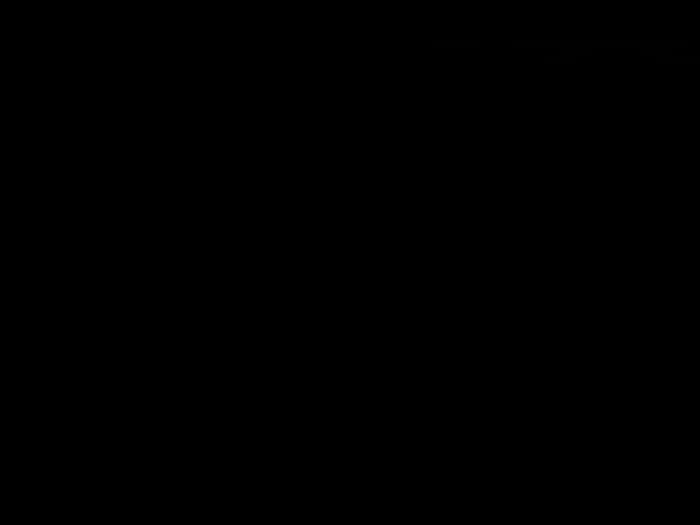

In [ ]:
import cv2 
import tensorflow as tf
from google.colab.patches import cv2_imshow
import keras

img_x = cv2.imread("/content/drive/MyDrive/Cars/car_models_data/car_data/car_data/train/AM General Hummer SUV 2000/00163.jpg")
# img = cv2.resize(img, (224, 224)) #self.resize_with_padding(img, (224, 224))
# img = np.expand_dims(img, axis=0)
img_2 = keras.applications.mobilenet.preprocess_input(img_x)
print(img_2)
cv2_imshow(img_2)